In [46]:
import ROOT
import pandas as pd
from array import array
from itertools import product

In [47]:
ERA = "2016postVFP"

In [48]:
# Binning
ABSETA_BINS = [0., 0.8, 1.479, 2.5]
PTCORR_BINS = [15., 20., 25., 35., 50, 100.]

In [49]:
# Fill Low PT bins
def parse_integral(hlt, id, syst):
    return pd.read_csv(f"../output/{ERA}/{hlt}/fitresult.{id}.{syst}.csv", index_col="prefix", sep=", ", engine="python")

In [50]:
# make an index based on pt and eta
# e.g. ptcorr_10_to_15_EB1
def get_prefix(eta, pt):
    # make pt prefix, e.g. ptcorr_10_to_15
    pt_prefix = f"ptcorr_{int(pt)}to{int(PTCORR_BINS[PTCORR_BINS.index(pt)+1])}"
    eta_prefix = ""
    if ABSETA_BINS.index(eta) == 0:
        eta_prefix = "EB1"
    elif ABSETA_BINS.index(eta) == 1:
        eta_prefix = "EB2"
    elif ABSETA_BINS.index(eta) == 2:
        eta_prefix = "EE"
    else:
        raise ValueError
    return f"{pt_prefix}_{eta_prefix}"

In [51]:
def parseIntegral(id, syst):
    h = ROOT.TH2D(f"h_{id}_{syst}", f"{id}_{syst}", len(ABSETA_BINS)-1, array("d", ABSETA_BINS),
                                                    len(PTCORR_BINS)-1, array("d", PTCORR_BINS))
    for eta, pt in product(ABSETA_BINS[:-1], PTCORR_BINS[:-1]):
        idx = get_prefix(eta, pt)
        hlt = "MeasFakeEl12" if pt < 35. else "MeasFakeEl23"
        csv = parse_integral(hlt, id, syst)
        data = csv.loc[idx, 'data']
        qcd = data*(csv.loc[idx, 'QCD_EMEnriched'] + csv.loc[idx, 'QCD_bcToE'])
        h.Fill(eta+0.001, pt+0.001, qcd)
    h.SetDirectory(0)
    return h

In [52]:
def get_fakerate(syst):
    h_loose = parseIntegral("loose", syst)
    h_tight = parseIntegral("tight", syst)

    h_fake = h_tight.Clone(f"fakerate_{syst}")
    h_fake.SetTitle(f"fake rate - {syst}")
    h_fake.Divide(h_loose)
    h_fake.SetDirectory(0)
    return h_fake

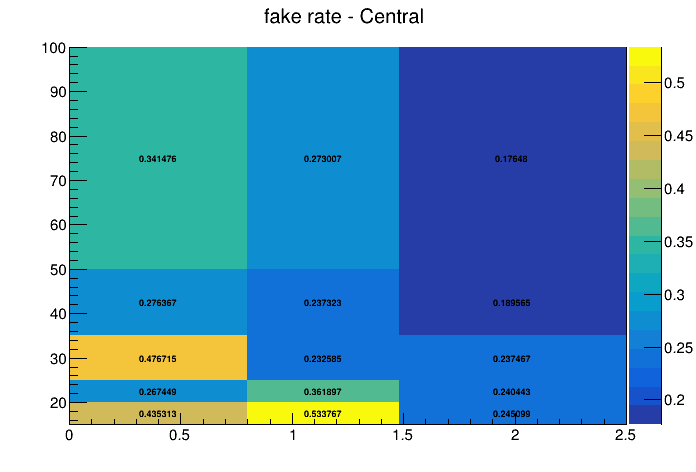

In [53]:
fake_central = get_fakerate("Central")
fake_btag = get_fakerate("RequireHeavyTag")

c = ROOT.TCanvas()
c.cd()
fake_central.SetStats(0)
fake_central.Draw("colz&text")
c.Draw()

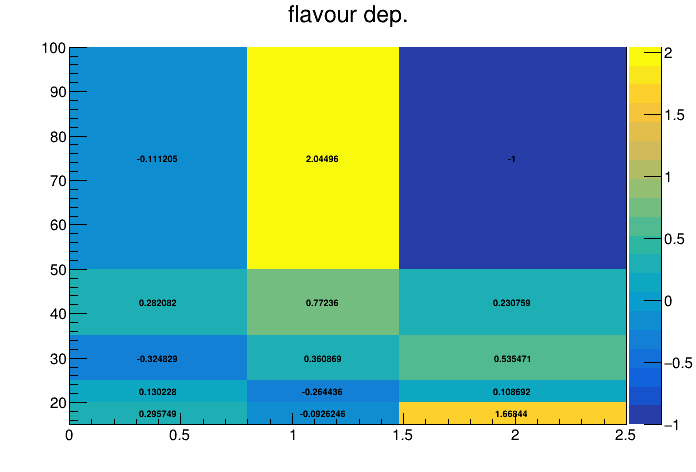

In [54]:
ratio = fake_btag.Clone("ratio")
ratio.SetTitle("flavour dep.")
ratio.Add(fake_central, -1)
ratio.Divide(fake_central)

c.cd()
ratio.SetStats(0)
ratio.Draw("colz&text")
c.Draw()